In [8]:
import tensorflow as tf
import cv2
import numpy as np
import scipy.io as sc
from glob import glob
import keras
from keras import layers

In [2]:
!unzip with_mask.zip;
!unzip without_mask.zip;

Archive:  with_mask.zip
replace with mask/14-with-mask.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  without_mask.zip
replace without mask/augmented_image_111.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!mkdir train;
!mv with_mask train;
!mv without_mask train;

### Set Up Data

In [3]:
from sklearn.model_selection import train_test_split
with_mask = glob('train/with_mask/*.jpg')
without_mask = glob('train/without_mask/*.jpg')
with_mask_train, with_mask_test = train_test_split(with_mask, test_size=0.1)
without_mask_train, without_mask_test = train_test_split(without_mask, test_size=0.1)


#moves the validation files out of the train directory and over to the val directory.

!mkdir val

!mkdir val/with_mask
files = ' '.join(with_mask_test)
!mv $files val/with_mask 

!mkdir val/without_mask
files = ' '.join(without_mask_test)
!mv $files val/without_mask

!rm -rf train/.ipynb_checkpoints
!rm -rf val/.ipynb_checkpoints


mkdir: cannot create directory ‘val’: File exists
mkdir: cannot create directory ‘val/with_mask’: File exists
mkdir: cannot create directory ‘val/without_mask’: File exists


Found 900 files belonging to 2 classes.
Found 476 files belonging to 2 classes.


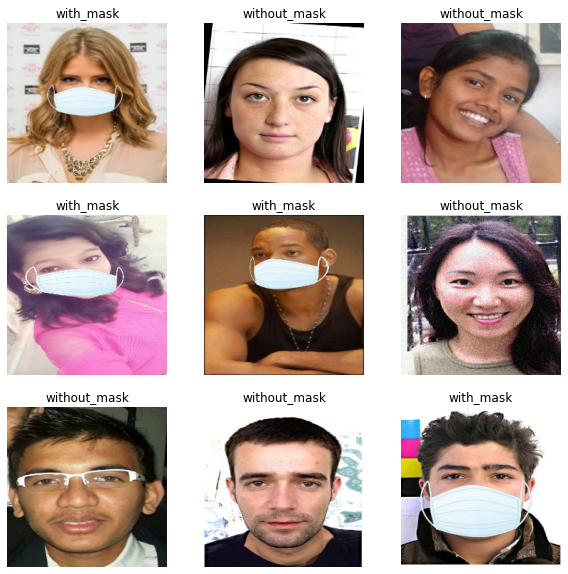

In [10]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory('./train', #sets up training dataset
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory('./val', #sets up validation dataset
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10)) 
for images, labels in train_dataset.take(1): #shows 9 examples of the training dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Augment data for training

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( #allow for rotation, zooming, and flipping of training images 
    rescale = 1./255.,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(#### 
    rescale = 1./255.,
#     rotation_range=90,
#     zoom_range=[1,2],
#     horizontal_flip=True,
#     fill_mode='nearest' 
)

train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    './val',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 900 images belonging to 2 classes.
Found 476 images belonging to 2 classes.


### Modify network

In [12]:
model = keras.applications.MobileNetV2() #pre-trained, 14MB, smallest available model
model.summary()

ise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]    

In [13]:
#creates base model from pretrained network trained on ImageNet dataset
#Here by setting include_top to false we exclude the classification layers at the end of the network
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

In [14]:
from keras import Model
from keras import layers
base_model.trainable = False #freeze the base weights, model has already learned these

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(base_model.output)

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)

# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# # Add a final sigmoid layer for classification
# x = layers.Dense(2, activation='sigmoid')(x)

# new_model = tf.keras.models.Model(base_model.input, x)

# flat_layer = keras.layers.Flatten()(base_model.output)
# x = layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output) # This layer is used to downsample the features
# flat_layer = keras.layers.Flatten()(x)
# # x = layers.Dropout(0.4)(flat_layer)                            # This layer is used to enforce feature redundancy 
# dense_layer = keras.layers.Dense(2, activation='softmax')(x) #binary output
# # final_output = layers.Activation('sigmoid')(dense_layer)
# new_model = keras.Model(inputs = base_model.input, outputs = dense_layer)

flat_layer = keras.layers.Flatten()(base_model.output)
dense_layer = keras.layers.Dense(2)(flat_layer) 
final_output = layers.Activation('softmax')(dense_layer)
new_model = keras.Model(inputs = base_model.input, outputs = final_output)

In [15]:
new_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [16]:
# EPOCHS = 5
# BATCH_SIZE = 10
# STEPS_PER_EPOCH = 5
# VALIDATION_STEPS = 1
EPOCHS = 8
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
# MODEL_FILE = 'filename.model'

# history = new_model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=validation_generator,
#     validation_steps=VALIDATION_STEPS)

MODEL_FILE = 'maskdetector.model'

hist = new_model.fit(train_generator, validation_data = validation_generator, validation_steps=1, steps_per_epoch = 5, epochs = 15)
# hist = model.fit(train_generator,epochs=5,validation_data=validation_generator)
new_model.save(MODEL_FILE)

Epoch 1/15
5/5 [==============================] - 13s 3s/step - loss: 1.2879 - acc: 0.6875 - val_loss: 0.1775 - val_acc: 0.9688
Epoch 2/15
5/5 [==============================] - 10s 2s/step - loss: 0.2796 - acc: 0.8938 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 3/15
5/5 [==============================] - 8s 2s/step - loss: 0.2346 - acc: 0.9250 - val_loss: 0.1499 - val_acc: 0.9688
Epoch 4/15
5/5 [==============================] - 10s 2s/step - loss: 0.4194 - acc: 0.8788 - val_loss: 0.1239 - val_acc: 0.9688
Epoch 5/15
5/5 [==============================] - 11s 2s/step - loss: 0.1364 - acc: 0.9438 - val_loss: 0.1228 - val_acc: 0.9375
Epoch 6/15
5/5 [==============================] - 12s 2s/step - loss: 0.1290 - acc: 0.9563 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 7/15
5/5 [==============================] - 11s 2s/step - loss: 0.1704 - acc: 0.9312 - val_loss: 0.0294 - val_acc: 0.9688
Epoch 8/15
5/5 [==============================] - 10s 2s/step - loss: 0.1258 - acc: 0.9563 - val_loss: 7.

[0.5837579  0.41624215]


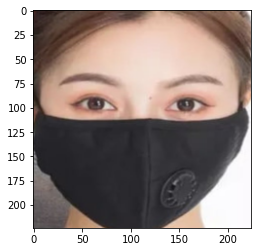

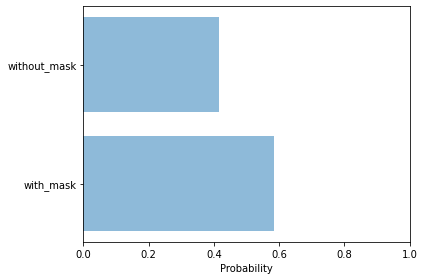

In [23]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
from facenet_pytorch import MTCNN
from torchvision import transforms
from PIL import Image
from IPython.display import clear_output
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]
# We plot the original image

plt.figure()
img = Image.open('testWith/test4.jpg')
# Get cropped tensor and convert to PIL image
mtcnn = MTCNN(image_size=224, margin=20, post_process=False)
img_cropped = mtcnn(img)
img_cropped = img_cropped.permute(1, 2, 0).int().numpy();
img_cropped = Image.fromarray(np.uint8(img_cropped))
plt.imshow(img_cropped)

preds = predict(load_model(MODEL_FILE), img_cropped)
print(preds)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["with_mask", "without_mask"]
plt.barh(range(2),preds,alpha=0.5)
plt.yticks(range(2),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()


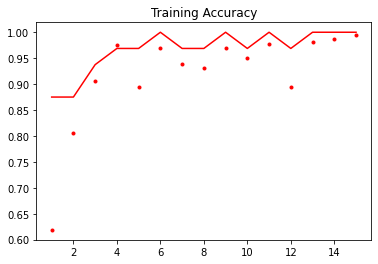

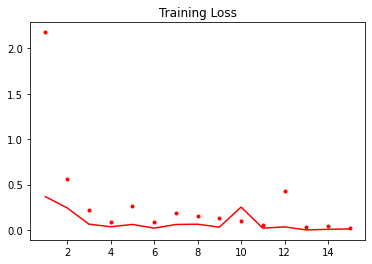

In [14]:
import matplotlib.pyplot as plt
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

In [26]:
import cv2
from PIL import Image
from threading import Thread
from keras.preprocessing import image
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
from facenet_pytorch import MTCNN
from torchvision import transforms
from PIL import Image
from IPython.display import clear_output

def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

def detect():
    mtcnn = MTCNN(image_size=224, margin=20, post_process=False)
    img_cropped = mtcnn(img)
    img_cropped = img_cropped.permute(1, 2, 0).int().numpy();
    img_cropped = Image.fromarray(np.uint8(img_cropped))
    #plt.imshow(img_cropped)

    preds = predict(load_model(MODEL_FILE), img_cropped)
    print(preds)

    # We can visualize the predicted likelihood of each class
    clear_output(wait=True)
    plt.figure()
    labels = ["with_mask", "without_mask"]
    plt.barh(range(2),preds,alpha=0.5)
    plt.yticks(range(2),labels)
    plt.xlabel('Probability')
    plt.xlim(0,1)
    plt.tight_layout()
    plt.show()
thread = Thread()
while rval:
    cv2.imshow("preview",frame)
    rval, frame = vc.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame)
    if(thread.is_alive() == False):
        thread = Thread(target=detect,)
        thread.start()

    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
cv2.destroyWindow("preview")